In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score, r2_score, mean_absolute_error, mean_squared_error,
    mean_absolute_percentage_error, mean_squared_log_error
)
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
import kerastuner as kt
import tensorflow as tf


C:\Users\barrc\AppData\Local\Temp\ipykernel_21368\45070964.py:26: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [2]:
df=pd.read_csv("concrete_data-1.csv", sep=",")


In [ ]:
colnames=df.columns

In [ ]:
df=df.to_numpy()

In [ ]:
scaler = MinMaxScaler()
model_sc=scaler.fit(df)
df=model_sc.transform(df)

In [ ]:
nrow=df.shape[0]
ncol=df.shape[1]

In [ ]:
idx=list(range(0,nrow))

In [ ]:
np.random.seed(seed=2343)
np.random.shuffle(idx)

In [ ]:
df=df[idx,]

In [ ]:
X=df[:,:-1]
y=df[:,-1]

In [ ]:
df.shape

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.175, random_state=42)

In [ ]:
ncol=X_train.shape[1]

In [3]:
def coeff_determination(y_true, y_pred):
    from keras import backend as K # type: ignore
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - (SS_res/SS_tot))

In [ ]:
def summary_regress(actual, predicted):
    a=mean_absolute_error(actual, predicted)
    b=mean_squared_error(actual, predicted)
    c= mean_squared_error(actual, predicted)**(1/2)
    d=r2_score(actual, predicted)
    return round(a,2),round(b,2),round(c,2),round(d,2)

In [ ]:
def summary_train_val_test(y_train_obs, y_train_pred,y_val_obs, y_val_pred,y_test_obs, y_test_pred):
  train=summary_regress(y_train_obs,y_train_pred)
  val=summary_regress(y_val_obs,y_val_pred)
  test=summary_regress(y_test_obs,y_test_pred)
  df=pd.DataFrame([train,val,test],index=["Train","Val","Test"],columns=["MAE","MSE","RMSE","R2"])
  return df

In [4]:
# Se crea modelo constructor
def build_model(hp):
    seed_value=3
    tf.random.set_seed(seed_value)
    hp_learning_rate = hp.Choice('learning_rate', values = [0.001, 0.01, 0.1])

    initializer = GlorotNormal(seed=seed_value)
    optimizer1 = Adam(lr=hp_learning_rate)

    model = Sequential()
    model.add(Dense(units=hp.Int('layers_units_x', 50, 250, step=10), input_dim = ncol,  kernel_initializer=initializer, activation='relu'))

    for i in range(hp.Int('layers_', 1, 6)):
        model.add(Dropout(rate=hp.Choice('dp_rate_'+ str(i), values = [0.25, 0.5, 0.75])))
        model.add(Dense(units=hp.Int('units_' + str(i), 50, 250, step=10),activation='relu',kernel_initializer=initializer))
        
    model.add(Dense(1, activation='linear'))

    model.compile(optimizer=optimizer1, loss='mse',metrics=['mean_absolute_percentage_error','mae',coeff_determination])
    return model

In [5]:
tuner = kt.RandomSearch(build_model,
                     objective = 'val_loss',
                     max_trials=150,
                     directory = '/content/Randomsearch',
                     project_name='Randomsearch_5')

Reloading Tuner from /content/Randomsearch\Randomsearch_5\tuner0.json


In [6]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(721, 8)
(721,)
(154, 8)
(154,)


In [7]:
nrow=X_train.shape[0]

In [8]:
tuner.search(X_train, y_train, epochs=60,batch_size=nrow,verbose=0,validation_data=(X_val, y_val))

In [9]:
best_model =tuner.get_best_models(num_models=1)[0]


In [10]:
best_hps = tuner.get_best_hyperparameters(num_trials = 5)[0].values


In [11]:
lrt1=best_hps['learning_rate']


In [12]:
print(lrt1)

0.001


In [13]:
best_model.get_config()

{'name': 'sequential',
 'layers': [{'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 8),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'dense_input'},
   'registered_name': None},
  {'module': 'keras.layers',
   'class_name': 'Dense',
   'config': {'name': 'dense',
    'trainable': True,
    'dtype': 'float32',
    'batch_input_shape': (None, 8),
    'units': 160,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'module': 'keras.initializers',
     'class_name': 'GlorotNormal',
     'config': {'seed': 3},
     'registered_name': None},
    'bias_initializer': {'module': 'keras.initializers',
     'class_name': 'Zeros',
     'config': {},
     'registered_name': None},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None},
   'registered_name': None,
   'build_config': {'input_sha

In [14]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 160)               1440      
                                                                 
 dropout (Dropout)           (None, 160)               0         
                                                                 
 dense_1 (Dense)             (None, 150)               24150     
                                                                 
 dense_2 (Dense)             (None, 1)                 151       
                                                                 
Total params: 25741 (100.55 KB)
Trainable params: 25741 (100.55 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
ytrain_pred=best_model.predict(X_train,verbose=0)
yval_pred=best_model.predict(X_val,verbose=0)
ytest_pred=best_model.predict(X_test,verbose=0)

summary_train_val_test(y_train,ytrain_pred,y_val,yval_pred,y_test,ytest_pred)

,MAE,MSE,RMSE,R2
Train,0.09,0.01,0.11,0.72
Val,0.08,0.01,0.10,0.78
Test,0.09,0.02,0.13,0.62


In [16]:
best_model.save('Modelo_Grid_1.h5', include_optimizer=True)

C:\Users\barrc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
# model = keras.models.load_model('Model_Grid_1.h5')
model = load_model('Modelo_Grid_1.h5', custom_objects={'coeff_determination': coeff_determination})

In [18]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', coeff_determination])

In [19]:
history = model.fit(X_train, y_train, epochs=380, validation_data=(X_val, y_val))

Epoch 1/380
23/23 [==============================] - 1s 9ms/step - loss: 0.0165 - mae: 0.1012 - coeff_determination: 0.5796 - val_loss: 0.0085 - val_mae: 0.0738 - val_coeff_determination: 0.7831
Epoch 2/380
23/23 [==============================] - 0s 3ms/step - loss: 0.0153 - mae: 0.0968 - coeff_determination: 0.6288 - val_loss: 0.0080 - val_mae: 0.0682 - val_coeff_determination: 0.7932
Epoch 3/380
23/23 [==============================] - 0s 2ms/step - loss: 0.0134 - mae: 0.0912 - coeff_determination: 0.6708 - val_loss: 0.0068 - val_mae: 0.0635 - val_coeff_determination: 0.8278
Epoch 4/380
23/23 [==============================] - 0s 2ms/step - loss: 0.0147 - mae: 0.0942 - coeff_determination: 0.6532 - val_loss: 0.0066 - val_mae: 0.0622 - val_coeff_determination: 0.8336
Epoch 5/380
23/23 [==============================] - 0s 3ms/step - loss: 0.0123 - mae: 0.0870 - coeff_determination: 0.6913 - val_loss: 0.0072 - val_mae: 0.0668 - val_coeff_determination: 0.8174
Epoch 6/380
23/23 [======

In [20]:
# Evaluar el modelo en los conjuntos de datos de entrenamiento, validación y prueba
train_loss, train_mae, train_r2 = model.evaluate(X_train, y_train, verbose=0)
val_loss, val_mae, val_r2 = model.evaluate(X_val, y_val, verbose=0)
test_loss, test_mae, test_r2 = model.evaluate(X_test, y_test, verbose=0)

In [21]:
# Calcular las predicciones
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

5/5 [==============================] - 0s 1ms/step


In [22]:
# Calcular las métricas utilizando las funciones de sklearn.metrics 
train_mse = mean_squared_error(y_train, y_train_pred)
val_mse = mean_squared_error(y_val, y_val_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

train_r2 = r2_score(y_train, y_train_pred)
val_r2 = r2_score(y_val, y_val_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Calcular RMSE a partir del MSE
train_rmse = np.sqrt(train_mse)
val_rmse = np.sqrt(val_mse)
test_rmse = np.sqrt(test_mse)

In [23]:
# Imprimir las métricas
print("Métricas de Train:")
print("Loss:", train_loss)
print("MAE:", train_mae)
print("MSE:", train_mse)
print("R2:", train_r2)
print("RMSE:", train_rmse)
print("\nMétricas de validación:")
print("Loss:", val_loss)
print("MAE:", val_mae)
print("MSE:", val_mse)
print("R2:", val_r2)
print("RMSE:", val_rmse)
print("\nMétricas de Test:")
print("Loss:", test_loss)
print("MAE:", test_mae)
print("MSE:", test_mse)
print("R2:", test_r2)
print("RMSE:", test_rmse)

Métricas de Train:
Loss: 0.000976897543296218
MAE: 0.021498965099453926
MSE: 0.0009768978411097895
R2: 0.9775394565694674
RMSE: 0.031255364997225504

Métricas de validación:
Loss: 0.0019814458210021257
MAE: 0.03189108520746231
MSE: 0.0019814459945730707
R2: 0.9538826774043113
RMSE: 0.04451343611285328

Métricas de Test:
Loss: 0.003854124341160059
MAE: 0.042217057198286057
MSE: 0.003854124074355098
R2: 0.9076732579338067
RMSE: 0.06208159207329575


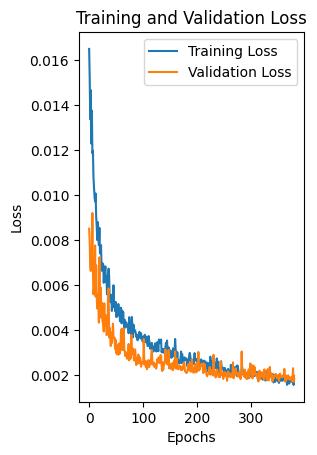

In [24]:
# Gráfico Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

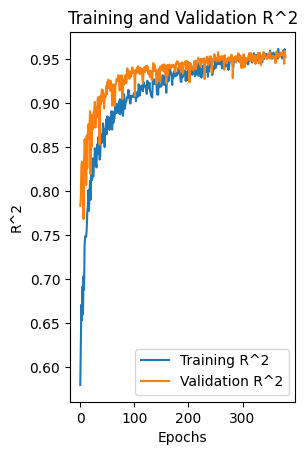

In [25]:
# Gráfico de R^2
plt.subplot(1, 2, 2)
plt.plot(history.history['coeff_determination'], label='Training R^2')
plt.plot(history.history['val_coeff_determination'], label='Validation R^2')
plt.title('Training and Validation R^2')
plt.xlabel('Epochs')
plt.ylabel('R^2')
plt.legend()
plt.show()

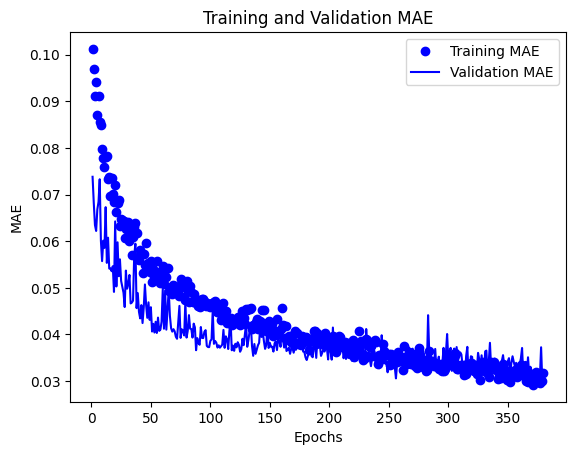

In [26]:
# Crea una lista de épocas
epochs = range(1, len(history.history['mae']) + 1)

# Grafica MAE de entrenamiento y validación
plt.plot(epochs, history.history['mae'], 'bo', label='Training MAE')
plt.plot(epochs, history.history['val_mae'], 'b', label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

# Muestra el gráfico
plt.show()